In [1]:
import os
import sys
import cortex
import numpy as np
import pandas as pd
import nibabel as nb
from PIL import Image
import matplotlib.pyplot as plt


# Personal imports
sys.path.append("{}/../../analysis_code/utils".format(os.getcwd()))
from surface_utils import load_surface ,make_surface_image
from pycortex_utils import load_surface_pycortex, set_pycortex_config_file, draw_cortex

In [2]:
# Directories
main_dir = '/Users/uriel/disks/meso_shared'
project_dir = 'RetinoMaps'

In [3]:
# Set pycortex db and colormaps
cortex_dir = "{}/{}/derivatives/pp_data/cortex".format(main_dir, project_dir)
set_pycortex_config_file(cortex_dir)

In [4]:
# Load annot
labels_lh, ctab_lh, names_lh = nb.freesurfer.read_annot("/Users/uriel/Desktop/freesurfer/sub-01/label/lh.HCPMMP1.annot")
labels_rh, ctab_rh, names_rh = nb.freesurfer.read_annot("/Users/uriel/Desktop/freesurfer/sub-01/label/rh.HCPMMP1.annot")



In [6]:
img_lh, roi_lh = load_surface('/Users/uriel/disks/meso_shared/RetinoMaps/derivatives/pp_data/sub-01/fsnative/rois/sub-01_hemi-L_rois.func.gii')
img_rh, roi_rh = load_surface('/Users/uriel/disks/meso_shared/RetinoMaps/derivatives/pp_data/sub-01/fsnative/rois/sub-01_hemi-R_rois.func.gii')


In [7]:
labels_lh = labels_lh.reshape(1, -1)
labels_rh = labels_rh.reshape(1, -1)

fs_mmp_img_lh = make_surface_image(data=labels_lh, source_img=img_lh)
fs_mmp_img_rh = make_surface_image(data=labels_rh, source_img=img_rh)


nb.save(fs_mmp_img_lh,'/Users/uriel/Downloads/mmp_fs_hemi-L.func.gii') 
nb.save(fs_mmp_img_rh,'/Users/uriel/Downloads/mmp_fs_hemi-R.func.gii') 

In [60]:
# mapping index -> nom (correct)
id_to_name_lh = {i: names_lh[i].decode() for i in range(len(names_lh))}
id_to_name_rh = {i: names_rh[i].decode() for i in range(len(names_rh))}

# dictionnaires ROI -> mask
roi_masks_lh = {}
roi_masks_rh = {}

for label_id, roi_name in id_to_name_lh.items():
    if roi_name == "???":
        continue

    # retire le préfixe L_ (seulement s'il est au début)
    if roi_name.startswith("L_"):
        roi_clean = roi_name[len("L_"):]
    else:
        roi_clean = roi_name

    # retire le suffixe _ROI (seulement s'il est à la fin)
    if roi_clean.endswith("_ROI"):
        roi_clean = roi_clean[:-len("_ROI")]

    roi_masks_lh[roi_clean] = (labels_lh == label_id)


for label_id, roi_name in id_to_name_rh.items():
    if roi_name == "???":
        continue

    if roi_name.startswith("R_"):
        roi_clean = roi_name[len("R_"):]
    else:
        roi_clean = roi_name

    if roi_clean.endswith("_ROI"):
        roi_clean = roi_clean[:-len("_ROI")]

    roi_masks_rh[roi_clean] = (labels_rh == label_id)

In [62]:
roi_list = [
 "V1",
 "V2",
 "V3", "V4",
 "V3A", "V3B", "V3CD",
 "LO1", "LO2", "LO3",
 "V8", "PIT", "PH", "FFC", "VMV1", "VMV2", "VMV3", "VVC",
 "V4t", "MST", "MT", "FST",
 "IP0", "IPS1", "V7", "MIP", "IP1", "V6A", "7PL",
 "VIP", "LIPv", "LIPd", "IP2", "7PC", "AIP", "7AL", "7Am", "7Pm",
 "PEF", "IFJp", "6v", "6r", "IFJa", "55b",
 "FEF", "i6-8", "6a", "6d", "6mp", "6ma",
 "SCEF", "p32pr", "24dv"
]

# Initialiser un masque vide (False)
mask_lh = np.zeros_like(labels_lh, dtype=bool)
mask_rh = np.zeros_like(labels_rh, dtype=bool)

# Remplir les masques
for roi in roi_list:
    roi_mask_lh = roi_masks_lh.get(roi)
    roi_mask_rh = roi_masks_rh.get(roi)

    if roi_mask_lh is None or roi_mask_rh is None:
        raise KeyError(f"ROI {roi} non trouvée dans LH ou RH")

    mask_lh |= roi_mask_lh
    mask_rh |= roi_mask_rh

# Concat LH + RH
roi_mask = np.concatenate([mask_lh, mask_rh]).reshape(1, -1)

# Convertir en 0/1
mask_int = roi_mask.astype(int)

# Plot

In [8]:
mmp_colormap_fn = '{}/db/sub-170k/Glasser2016_ColorLUT.txt'.format(cortex_dir)
# creating an MMP colormap as png
np_cmap = pd.read_csv(mmp_colormap_fn, delimiter='\t')[[' R ',' G ',' B ', ' A ']].astype(np.uint8)
np_cmap[' A '] = np.ones(np_cmap.shape[0], dtype=np.uint8) * 255
png = np.zeros((1,256,4), dtype=np.uint8)
png[0,:np.array(np_cmap).shape[0],:] = np.array(np_cmap)
im = Image.fromarray(png, 'RGBA')
im.save('{}/colormaps/HCP_MMP1.png'.format(cortex_dir))
plt.matshow(png)
plt.axis('off')

(np.float64(-0.5), np.float64(255.5), np.float64(0.5), np.float64(-0.5))

In [31]:
results = load_surface_pycortex(L_fn='/Users/uriel/Downloads/mmp_fs_hemi-L.func.gii', 
                                R_fn='/Users/uriel/Downloads/mmp_fs_hemi-R.func.gii')
deriv_mat = results['data_concat']

In [32]:
pycortex_subject = 'sub-01'
colormap_name = 'HCP_MMP1'

In [33]:
alpha_mat = np.ones(deriv_mat.shape)


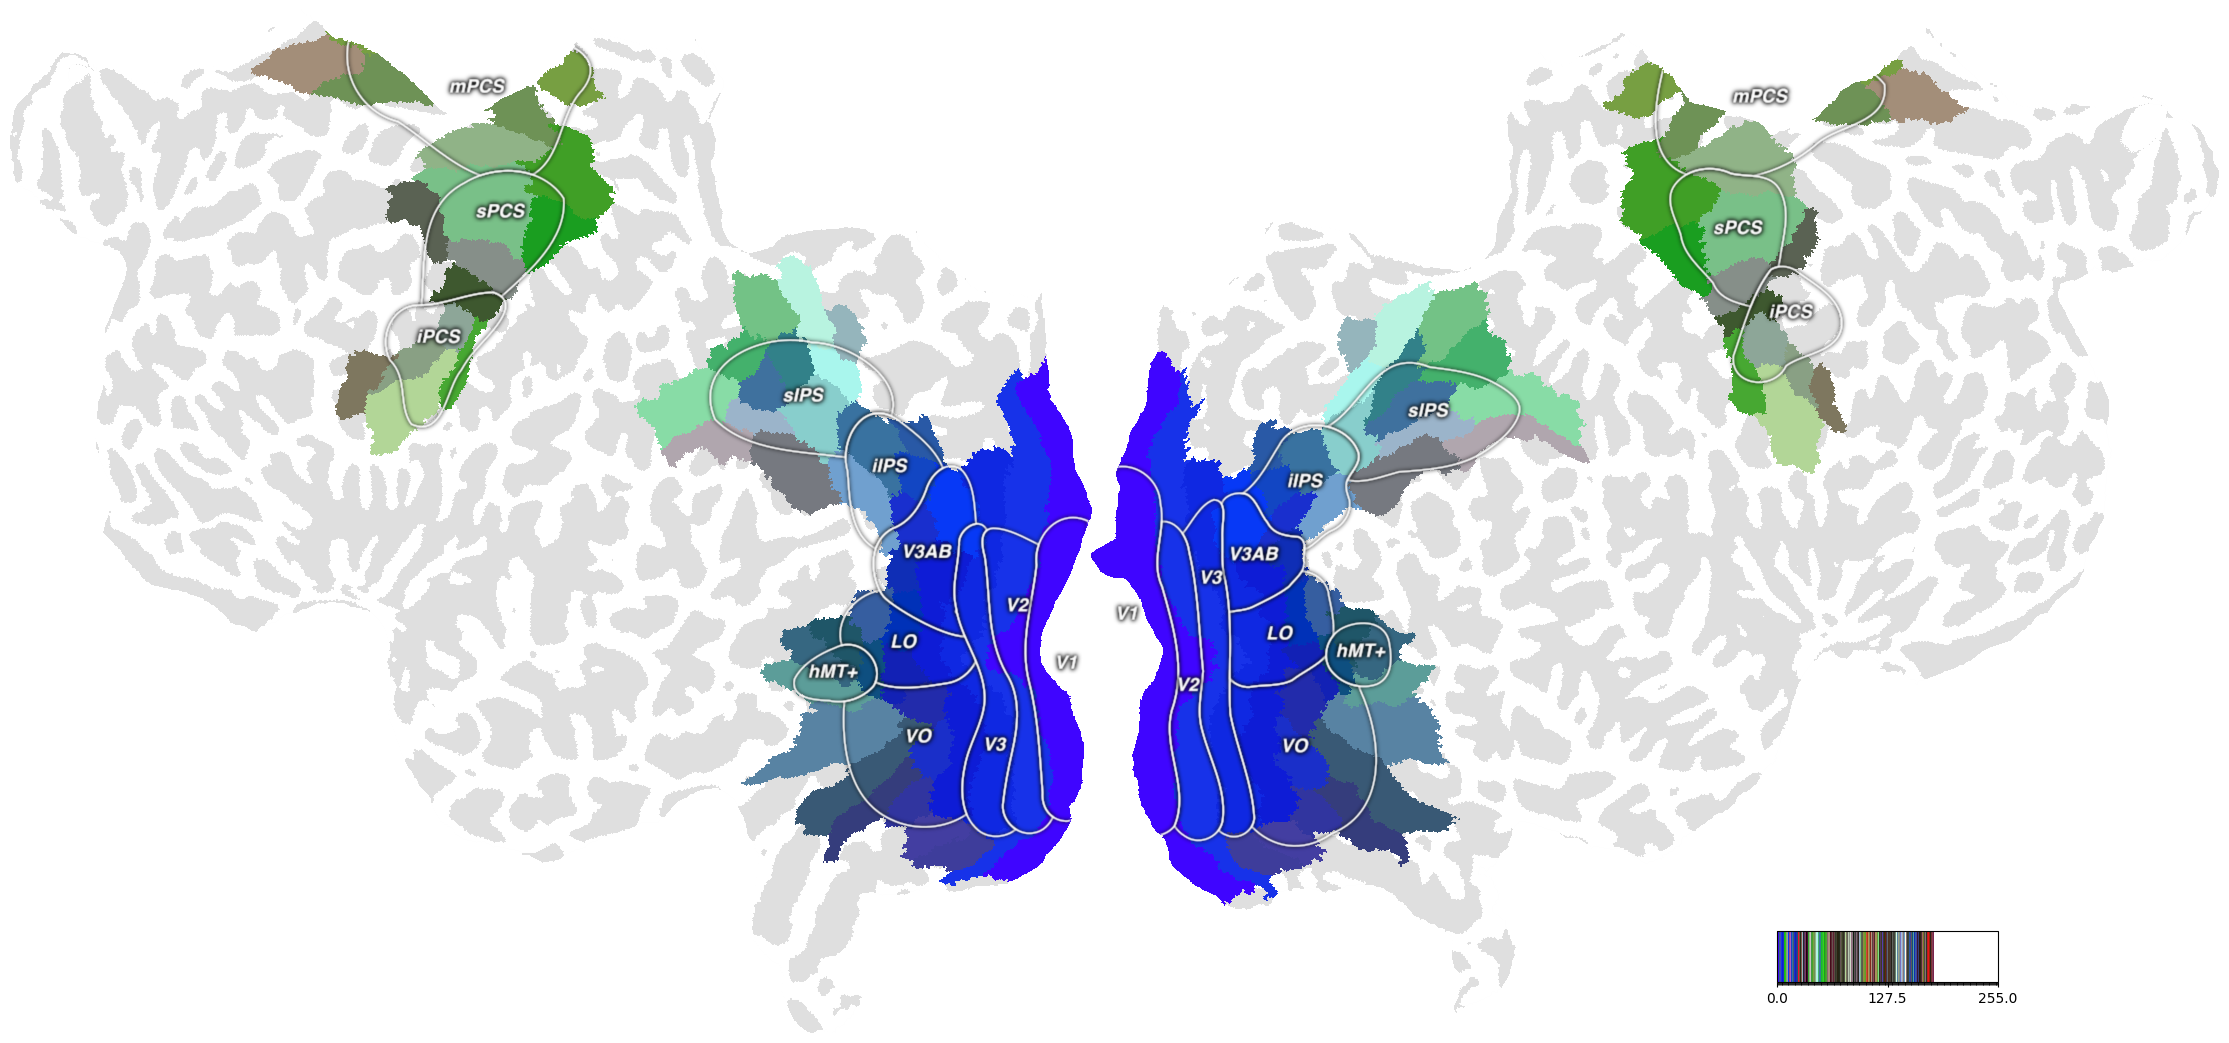

In [63]:
# Pycortex settings
roi_name = 'mmp_fsnayive'
param_rois = {'subject': pycortex_subject,
              'data': deriv_mat, 
              'cmap': colormap_name,
              'alpha': mask_int,
              'cbar': 'discrete', 
              'vmin': 0,
              'vmax': 255,
              'cmap_steps': 255,
              'cortex_type': 'VertexRGB',
              'description': 'Gaussian pRF ROIs',
              'curv_brightness': 1, 
              'curv_contrast': 0.25,
              'add_roi': False,
              'with_labels': True,
              'roi_name': roi_name}

# Plot
volume_roi = draw_cortex(**param_rois)
plt.savefig('/Users/uriel/Downloads/mmp_atlas.pdf')

In [41]:
# pycortex_subject = 'sub-01'
# colormap_name = 'HCP_MMP1'
# # plot mmp 
# vertex_data = cortex.Vertex(deriv_mat, pycortex_subject, cmap=colormap_name)

# cortex.quickshow(vertex_data, with_colorbar=False)
# plt.title("MMP atlas", fontsize=25)

# plt.show()

In [1]:
import os
import shutil
from cortex import svgoverlay

print("INKSCAPE env var:", os.environ.get("INKSCAPE"))
print("which inkscape   :", shutil.which("inkscape"))
print("pycortex version :", svgoverlay.INKSCAPE_VERSION)

INKSCAPE env var: None
which inkscape   : None
pycortex version : None


In [1]:
import os, shutil
print(os.environ["PATH"])
print(shutil.which("inkscape"))

/Applications/Inkscape.app/Contents/MacOS:/Users/uriel/softwares/anaconda3/envs/nCSF_env/bin:/Users/uriel/softwares/anaconda3/condabin:/usr/bin:/bin:/usr/sbin:/sbin
/Applications/Inkscape.app/Contents/MacOS/inkscape


In [ ]:
    ["V1"]
    ["V2"]
    ["V3", "V4"]
    ["V3A", "V3B", "V3CD"]
    ["LO1", "LO2", "LO3"] 
    ["V8", "PIT", "PH", "FFC", "VMV1", "VMV2", "VMV3", "VVC"]
    ["V4t", "MST", "MT", "FST"]
    ["IP0", "IPS1", "V7", "MIP", "IP1", "V6A", "7PL"]
    ["VIP", "LIPv", "LIPd", "IP2", "7PC", "AIP", "7AL", "7Am", "7Pm"]
    ["PEF", "IFJp", "6v", "6r", "IFJa", "55b"] 
    ["FEF", "i6-8", "6a", "6d", "6mp", "6ma"] 
    ["SCEF", "p32pr", "24dv"]